## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_pre_a(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
            x = BatchNormalization()(x)
            
        else:

            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
            x = BatchNormalization()(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95
MODE = ['pre_a', 'post_a']

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for mode in MODE:
    for batchsize in BATCH_SIZE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        if mode == 'pre_a':
            model = build_mlp_pre_a(input_shape=x_train.shape[1:])
        else:
            model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=batchsize, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
    
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
    
        exp_name_tag = "exp-l2-%s-%s" %(mode, str(batchsize))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
__________

50000/50000 [==============================] - 268s 5ms/step - loss: 2.2722 - acc: 0.1413 - val_loss: 2.2425 - val_acc: 0.1872
Epoch 49/50
50000/50000 [==============================] - 268s 5ms/step - loss: 2.2660 - acc: 0.1477 - val_loss: 2.3647 - val_acc: 0.1573
Epoch 50/50
50000/50000 [==============================] - 269s 5ms/step - loss: 2.2685 - acc: 0.1444 - val_loss: 2.2924 - val_acc: 0.1638
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_

50000/50000 [==============================] - 34s 687us/step - loss: 0.6612 - acc: 0.7661 - val_loss: 1.4372 - val_acc: 0.5545
Epoch 46/50
50000/50000 [==============================] - 34s 682us/step - loss: 0.6599 - acc: 0.7686 - val_loss: 1.4391 - val_acc: 0.5519
Epoch 47/50
50000/50000 [==============================] - 34s 681us/step - loss: 0.6425 - acc: 0.7742 - val_loss: 1.4548 - val_acc: 0.5476
Epoch 48/50
50000/50000 [==============================] - 34s 684us/step - loss: 0.6325 - acc: 0.7779 - val_loss: 1.4623 - val_acc: 0.5540
Epoch 49/50
50000/50000 [==============================] - 34s 685us/step - loss: 0.6340 - acc: 0.7780 - val_loss: 1.4575 - val_acc: 0.5522
Epoch 50/50
50000/50000 [==============================] - 34s 690us/step - loss: 0.6187 - acc: 0.7805 - val_loss: 1.4984 - val_acc: 0.5448
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072

50000/50000 [==============================] - 18s 353us/step - loss: 0.3698 - acc: 0.8696 - val_loss: 1.8558 - val_acc: 0.5380
Epoch 43/50
50000/50000 [==============================] - 18s 352us/step - loss: 0.3517 - acc: 0.8767 - val_loss: 1.8447 - val_acc: 0.5415
Epoch 44/50
50000/50000 [==============================] - 18s 354us/step - loss: 0.3511 - acc: 0.8746 - val_loss: 1.8629 - val_acc: 0.5441
Epoch 45/50
50000/50000 [==============================] - 18s 354us/step - loss: 0.3413 - acc: 0.8789 - val_loss: 1.8512 - val_acc: 0.5390
Epoch 46/50
50000/50000 [==============================] - 18s 355us/step - loss: 0.3339 - acc: 0.8816 - val_loss: 1.8986 - val_acc: 0.5388
Epoch 47/50
50000/50000 [==============================] - 18s 358us/step - loss: 0.3240 - acc: 0.8860 - val_loss: 1.9350 - val_acc: 0.5373
Epoch 48/50
50000/50000 [==============================] - 18s 360us/step - loss: 0.3151 - acc: 0.8905 - val_loss: 1.9380 - val_acc: 0.5394
Epoch 49/50
50000/50000 [=======

50000/50000 [==============================] - 6s 129us/step - loss: 0.1009 - acc: 0.9693 - val_loss: 2.4628 - val_acc: 0.5110
Epoch 40/50
50000/50000 [==============================] - 6s 129us/step - loss: 0.0982 - acc: 0.9710 - val_loss: 2.5359 - val_acc: 0.5180
Epoch 41/50
50000/50000 [==============================] - 6s 128us/step - loss: 0.0966 - acc: 0.9705 - val_loss: 2.5345 - val_acc: 0.5152
Epoch 42/50
50000/50000 [==============================] - 6s 128us/step - loss: 0.0876 - acc: 0.9738 - val_loss: 2.5286 - val_acc: 0.5192
Epoch 43/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.0874 - acc: 0.9734 - val_loss: 2.5247 - val_acc: 0.5167
Epoch 44/50
50000/50000 [==============================] - 6s 128us/step - loss: 0.0885 - acc: 0.9721 - val_loss: 2.5842 - val_acc: 0.5147
Epoch 45/50
50000/50000 [==============================] - 6s 128us/step - loss: 0.0779 - acc: 0.9771 - val_loss: 2.6117 - val_acc: 0.5125
Epoch 46/50
50000/50000 [==============

Epoch 37/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.0738 - acc: 0.9868 - val_loss: 2.3716 - val_acc: 0.5018
Epoch 38/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.0745 - acc: 0.9859 - val_loss: 2.3944 - val_acc: 0.5070
Epoch 39/50
50000/50000 [==============================] - 4s 86us/step - loss: 0.0617 - acc: 0.9896 - val_loss: 2.4266 - val_acc: 0.5057
Epoch 40/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.0632 - acc: 0.9890 - val_loss: 2.4425 - val_acc: 0.5061
Epoch 41/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.0578 - acc: 0.9901 - val_loss: 2.4777 - val_acc: 0.5007
Epoch 42/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.0532 - acc: 0.9911 - val_loss: 2.5112 - val_acc: 0.5030
Epoch 43/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.0491 - acc: 0.9922 - val_loss: 2.5414 - val_acc: 0.4992
Epoch 44/50
50000/50000 [=========

50000/50000 [==============================] - 247s 5ms/step - loss: 2.2508 - acc: 0.1607 - val_loss: 3.2369 - val_acc: 0.2160
Epoch 36/50
50000/50000 [==============================] - 247s 5ms/step - loss: 2.2398 - acc: 0.1634 - val_loss: 3.2115 - val_acc: 0.2051
Epoch 37/50
50000/50000 [==============================] - 247s 5ms/step - loss: 2.2324 - acc: 0.1731 - val_loss: 3.4715 - val_acc: 0.1983
Epoch 38/50
50000/50000 [==============================] - 247s 5ms/step - loss: 2.2363 - acc: 0.1667 - val_loss: 3.4475 - val_acc: 0.1915
Epoch 39/50
50000/50000 [==============================] - 246s 5ms/step - loss: 2.2425 - acc: 0.1656 - val_loss: 3.6680 - val_acc: 0.2077
Epoch 40/50
50000/50000 [==============================] - 246s 5ms/step - loss: 2.2441 - acc: 0.1653 - val_loss: 3.8823 - val_acc: 0.1807
Epoch 41/50
50000/50000 [==============================] - 245s 5ms/step - loss: 2.2541 - acc: 0.1531 - val_loss: 3.9196 - val_acc: 0.1887
Epoch 42/50
50000/50000 [==============

50000/50000 [==============================] - 32s 647us/step - loss: 1.1752 - acc: 0.5838 - val_loss: 1.3664 - val_acc: 0.5208
Epoch 34/50
50000/50000 [==============================] - 32s 642us/step - loss: 1.1719 - acc: 0.5842 - val_loss: 1.3677 - val_acc: 0.5204
Epoch 35/50
50000/50000 [==============================] - 32s 648us/step - loss: 1.1835 - acc: 0.5810 - val_loss: 1.3829 - val_acc: 0.5117
Epoch 36/50
50000/50000 [==============================] - 32s 645us/step - loss: 1.1709 - acc: 0.5862 - val_loss: 1.3598 - val_acc: 0.5140
Epoch 37/50
50000/50000 [==============================] - 32s 646us/step - loss: 1.1727 - acc: 0.5855 - val_loss: 1.3527 - val_acc: 0.5268
Epoch 38/50
50000/50000 [==============================] - 33s 653us/step - loss: 1.1652 - acc: 0.5877 - val_loss: 1.3743 - val_acc: 0.5154
Epoch 39/50
50000/50000 [==============================] - 33s 653us/step - loss: 1.1530 - acc: 0.5921 - val_loss: 1.3984 - val_acc: 0.5085
Epoch 40/50
50000/50000 [=======

50000/50000 [==============================] - 17s 331us/step - loss: 0.9620 - acc: 0.6569 - val_loss: 1.4444 - val_acc: 0.5187
Epoch 32/50
50000/50000 [==============================] - 17s 340us/step - loss: 0.9521 - acc: 0.6616 - val_loss: 1.4909 - val_acc: 0.5093
Epoch 33/50
50000/50000 [==============================] - 17s 335us/step - loss: 0.9422 - acc: 0.6625 - val_loss: 1.4168 - val_acc: 0.5198
Epoch 34/50
50000/50000 [==============================] - 17s 336us/step - loss: 0.9394 - acc: 0.6639 - val_loss: 1.4420 - val_acc: 0.5164
Epoch 35/50
50000/50000 [==============================] - 17s 341us/step - loss: 0.9378 - acc: 0.6646 - val_loss: 1.4126 - val_acc: 0.5266
Epoch 36/50
50000/50000 [==============================] - 16s 328us/step - loss: 0.9201 - acc: 0.6702 - val_loss: 1.4986 - val_acc: 0.4968
Epoch 37/50
50000/50000 [==============================] - 16s 329us/step - loss: 0.9057 - acc: 0.6771 - val_loss: 1.5117 - val_acc: 0.5018
Epoch 38/50
50000/50000 [=======

50000/50000 [==============================] - 6s 122us/step - loss: 0.5480 - acc: 0.8096 - val_loss: 1.9198 - val_acc: 0.4861
Epoch 30/50
50000/50000 [==============================] - 6s 123us/step - loss: 0.5288 - acc: 0.8168 - val_loss: 1.8607 - val_acc: 0.4767
Epoch 31/50
50000/50000 [==============================] - 6s 117us/step - loss: 0.5053 - acc: 0.8247 - val_loss: 2.0288 - val_acc: 0.4757
Epoch 32/50
50000/50000 [==============================] - 6s 121us/step - loss: 0.4885 - acc: 0.8302 - val_loss: 2.0217 - val_acc: 0.4623
Epoch 33/50
50000/50000 [==============================] - 6s 122us/step - loss: 0.4710 - acc: 0.8370 - val_loss: 2.0089 - val_acc: 0.4662
Epoch 34/50
50000/50000 [==============================] - 6s 117us/step - loss: 0.4544 - acc: 0.8435 - val_loss: 2.0020 - val_acc: 0.4685
Epoch 35/50
50000/50000 [==============================] - 6s 120us/step - loss: 0.4345 - acc: 0.8516 - val_loss: 2.3500 - val_acc: 0.4425
Epoch 36/50
50000/50000 [==============

Epoch 28/50
50000/50000 [==============================] - 4s 80us/step - loss: 0.5265 - acc: 0.8261 - val_loss: 1.8658 - val_acc: 0.4704
Epoch 29/50
50000/50000 [==============================] - 4s 80us/step - loss: 0.4993 - acc: 0.8366 - val_loss: 1.9607 - val_acc: 0.4584
Epoch 30/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.4790 - acc: 0.8444 - val_loss: 1.9521 - val_acc: 0.4614
Epoch 31/50
50000/50000 [==============================] - 4s 81us/step - loss: 0.4582 - acc: 0.8520 - val_loss: 1.9704 - val_acc: 0.4554
Epoch 32/50
50000/50000 [==============================] - 4s 81us/step - loss: 0.4408 - acc: 0.8583 - val_loss: 2.0380 - val_acc: 0.4514
Epoch 33/50
50000/50000 [==============================] - 4s 80us/step - loss: 0.4146 - acc: 0.8685 - val_loss: 2.1279 - val_acc: 0.4544
Epoch 34/50
50000/50000 [==============================] - 4s 81us/step - loss: 0.3963 - acc: 0.8747 - val_loss: 2.0363 - val_acc: 0.4671
Epoch 35/50
50000/50000 [=========

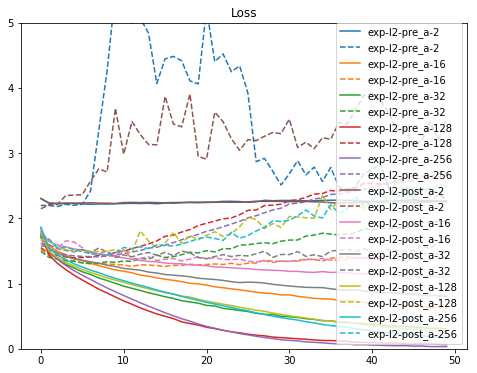

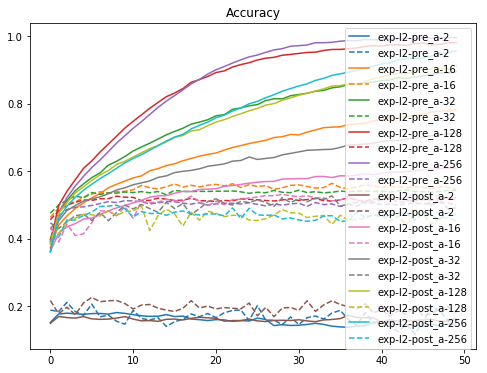

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()